In [ ]:
import os
import zipfile
from tensorflow.keras.utils import get_file


# Download url of normal CT scans.
url = 'https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip'
file_name = os.path.join(os.getcwd(), 'CT-0.zip')
get_file(fname=file_name, origin=url)

# Download url of abnormal CT scans.
url = 'https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip'
file_name = os.path.join(os.getcwd(), 'CT-23.zip')
get_file(fname=file_name, origin=url)

# Make a directory to store the data.
os.makedirs('MosMedData')

# Unzip data in the newly created directory.
with zipfile.ZipFile('CT-0.zip', 'r') as z_fp:
    z_fp.extractall('./MosMedData/')

with zipfile.ZipFile('CT-23.zip', 'r') as z_fp:
    z_fp.extractall('./MosMedData/')

1045168128/1045162547 [==============================] - 23s 0us/step


In [ ]:
import random
import nibabel as nib
import tensorflow as tf
from scipy import ndimage


def read_file(file_path):
    """ Read and load volume """
    scan = nib.load(filename=file_path)
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """ Normalize the volume """
    minimum = -1000
    maximum = 400

    volume[volume < minimum] = minimum
    volume[volume > maximum] = maximum

    volume = (volume - minimum) / (maximum - minimum)
    volume = volume.astype('float32')

    return volume


def resize_volume(img):
    """ Resize volume across z-axis """
    desired_depth = 64
    desired_width = 128
    desired_height = 128

    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height

    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    img = ndimage.rotate(input=img, angle=90, reshape=False)
    img = ndimage.zoom(input=img, zoom=(width_factor, height_factor, depth_factor), order=1)

    return img


def process_scan(path):
    """ Process volume """
    volume = read_file(file_path=path)
    volume = normalize(volume=volume)
    volume = resize_volume(img=volume)

    return volume


def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume_):
        angles = [-20, -10, -5, 5, 10, 20]
        angle = random.choice(angles)
        volume_ = ndimage.rotate(input=volume_, angle=angle, reshape=False)
        volume_[volume_ < 0] = 0
        volume_[volume_ > 1] = 1

        return volume_

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)

    return augmented_volume


def train_prepare(volume, label):
    volume = rotate(volume=volume)
    volume = tf.expand_dims(input=volume, axis=3)

    return volume, label


def validation_prepare(volume, label):
    volume = rotate(volume=volume)
    volume = tf.expand_dims(input=volume, axis=3)

    return volume, label

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model


def get_model(width=128, height=128, depth=64):
    """ Build a 3D convolution neural network model """

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    plot_model(model=model, show_shapes=True)

    return model

Epoch 1/50
70/70 [==============================] - 61s 427ms/step - loss: 0.6719 - accuracy: 0.4996 - val_loss: 0.8144 - val_accuracy: 0.5000
Epoch 2/50
70/70 [==============================] - 30s 430ms/step - loss: 0.7016 - accuracy: 0.5966 - val_loss: 1.1441 - val_accuracy: 0.5000
Epoch 3/50
70/70 [==============================] - 30s 426ms/step - loss: 0.6618 - accuracy: 0.5653 - val_loss: 1.3832 - val_accuracy: 0.5000
Epoch 4/50
70/70 [==============================] - 30s 428ms/step - loss: 0.7009 - accuracy: 0.5806 - val_loss: 2.3381 - val_accuracy: 0.5000
Epoch 5/50
70/70 [==============================] - 30s 428ms/step - loss: 0.6977 - accuracy: 0.6535 - val_loss: 2.0617 - val_accuracy: 0.5000
Epoch 6/50
70/70 [==============================] - 30s 427ms/step - loss: 0.6415 - accuracy: 0.6334 - val_loss: 1.6075 - val_accuracy: 0.5000
Epoch 7/50
70/70 [==============================] - 30s 428ms/step - loss: 0.5502 - accuracy: 0.7270 - val_loss: 2.4295 - val_accuracy: 0.5000

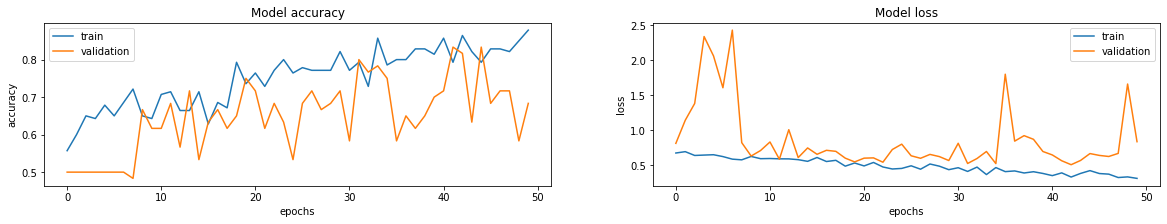

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

#from dataPreprocess import process_scan, train_prepare, validation_prepare
#from model import get_model


normal_scan_paths = []
for x in os.listdir('MosMedData/CT-0'):
    normal_scan_paths.append(os.path.join(os.getcwd(), 'MosMedData/CT-0', x))

abnormal_scan_paths = []
for x in os.listdir('MosMedData/CT-23'):
    abnormal_scan_paths.append(os.path.join(os.getcwd(), 'MosMedData/CT-23', x))


''' Each scan is resized across height, width, and depth and rescaled '''
normal_scans = np.array([process_scan(path=path) for path in normal_scan_paths])
# print(normal_scans.shape)  # (100, 128, 128, 64)

abnormal_scans = np.array([process_scan(path=path) for path in abnormal_scan_paths])
# print(abnormal_scans.shape)  # (100, 128, 128, 64)


''' For the CT scans having presence of viral pneumonia assign 1, for the normal ones assign 0 '''
normal_labels = np.array([0 for _ in range(len(normal_scan_paths))])
abnormal_labels = np.array([1 for _ in range(len(abnormal_scan_paths))])


''' Split data in the ratio 70:30 for training and validation '''
scan_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
scan_validate = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)

label_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
label_validate = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

# print(scan_train.shape)  # (140, 128, 128, 64)
# print(scan_validate.shape)  # (60, 128, 128, 64)
# print(label_train.shape)  # (140,)
# print(label_validate.shape)  # (60,)


''' Define data loaders '''
train_loader = tf.data.Dataset.from_tensor_slices((scan_train, label_train))
validation_loader = tf.data.Dataset.from_tensor_slices((scan_validate, label_validate))

batch_size = 2


''' Augment on the fly during training '''
train_data = (
    train_loader.shuffle(len(scan_train)).map(train_prepare).batch(batch_size).prefetch(2)
)

validation_data = (
    validation_loader.shuffle(len(scan_validate)).map(validation_prepare).batch(batch_size).prefetch(2)
)

# data = train_data.take(1)
# images, labels = list(data)[0]
# images = images.numpy()
# image = images[0]
# print(images.shape)  # (2, 128, 128, 64, 1)
# print(image.shape)  # (128, 128, 64, 1)
# print(image[:, :, 30].shape)  # (128, 128, 1)


''' Build model '''
model = get_model(width=128, height=128, depth=64)
# model.summary()


''' Compile model '''
initial_lr = 0.0001
lr_schedule = ExponentialDecay(initial_learning_rate=initial_lr, decay_steps=100000, decay_rate=0.96, staircase=True)

model.compile(optimizer=Adam(learning_rate=lr_schedule), loss="binary_crossentropy", metrics=['accuracy'])


''' Define callbacks '''
checkpoint_callback = ModelCheckpoint(filepath='3d_image_classification.h5', monitor='val_accuracy', save_best_only=True)
early_stop_callback = EarlyStopping(monitor='val_accuracy', patience=15)


''' Train the model, doing validation at the end of each epoch '''
epoch = 50

model.fit(
    train_data,
    epochs=epoch,
    verbose=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    validation_data=validation_data
)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 3))
ax = ax.ravel()
for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'validation'])



model.load_weights('3d_image_classification.h5')

prediction = model.predict(np.expand_dims(scan_validate[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_name = ['normal', 'abnormal']
for score, name in zip(scores, class_name):
    print(
        'This model is %.2f percent confident this CT scan is %s' % ((100 * score), name)
    )